<a href="https://colab.research.google.com/github/OzasaHiro/Kaggle_Contrail/blob/main/2D_DeepLabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Access

In [64]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from google.colab import auth, drive

# basic modules
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm
from datetime import datetime
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display

# pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision.transforms import Normalize
from torch.multiprocessing import Pool

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torch.optim import lr_scheduler

from timm.scheduler import CosineLRScheduler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#auth.authenticate_user()

In [3]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=fa854201b8b3c25915485eab82161f0c0702d44f36dd1a0a99c7865e04b9984f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=1ab1e1768b42fba2c3c2b36a1314e

In [4]:
#!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-nfws48m0
  Running command git clone --filter=blob:none --quiet https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-nfws48m0
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 12d03c07553aedd3d9e9155e2b3e31ce8c64081a
  Preparing metadata (setup.py) ... done
  Created wheel for cosine-annealing-warmup: filename=cosine_annealing_warmup-2.0-py3-none-any.whl size=4168 sha256=b82644e4a3a438068f5a080304d7df9c78364a07b56deb055f98eb99f87741f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-4bdpbyqz/wheels/29/26/10/bf1a07417dd54aa73bdf09ce4f31c187974a444a1cedddbd99
Successfully built cosine-annealing-warmup


In [5]:
import segmentation_models_pytorch as smp
#from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

In [6]:
#!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
#!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
#!apt-get -y -q update
#!apt-get -y -q install gcsfuse

deb http://packages.cloud.google.com/apt gcsfuse-focal main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k
OK
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,581 

GSC-Path : from https://www.kaggle.com/ozhiro/contrail-gcs-path/edit

In [7]:
#!mkdir -p data
#!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 "kds-b643cecc5077e52338720a4d4784002132e332215204036cd5dced04" data

I0529 01:19:38.066750 2023/05/29 01:19:38.066726 Start gcsfuse/0.42.5 (Go version go1.20.3) for app "" using mount point: /content/data


In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
save_dir = '.'
EXPERIMENT = 'Unet2D_DeepLabV3'
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')

save_dir = f'/content/drive/MyDrive/Contrail/experiments-{EXPERIMENT}/{run_ts}'
print(save_dir)

!mkdir -p {save_dir}

/content/drive/MyDrive/Contrail/experiments-Unet2D_DeepLabV3/20230529-011955


In [10]:
base_dir = '/content/drive/MyDrive/Contrail/data/' #'/content/data/'  #'/content/drive/MyDrive/Contrail/data/'  #"/kaggle/input/google-research-identify-contrails-reduce-global-warming/"
train_path = os.path.join(base_dir,"train")
#train_path = os.path.join(base_dir,"train_ExistContrail")
test_path = os.path.join(base_dir,"test")
val_path = os.path.join(base_dir,"validation")

#train_ids = os.listdir(train_path)
#test_ids = os.listdir(test_path)
#val_ids = os.listdir(val_path)

#np.savetxt("/content/drive/MyDrive/Contrail/train_ids.csv", train_ids, delimiter =",",fmt ='% s')
#np.savetxt("/content/drive/MyDrive/Contrail/test_ids.csv", test_ids, delimiter =",",fmt ='% s')
#np.savetxt("/content/drive/MyDrive/Contrail/val_ids.csv", val_ids, delimiter =",",fmt ='% s')

#train_ids = np.loadtxt("/content/drive/MyDrive/Contrail/train_ids_ExistContrail.csv", delimiter=",", dtype = "unicode")
train_ids = np.loadtxt("/content/drive/MyDrive/Contrail/train_ids.csv", delimiter=",", dtype = "unicode")
train_ids = train_ids.tolist()
test_ids = np.loadtxt("/content/drive/MyDrive/Contrail/test_ids.csv", delimiter=",", dtype = "unicode")
test_ids = test_ids.tolist()
val_ids = np.loadtxt("/content/drive/MyDrive/Contrail/val_ids.csv", delimiter=",", dtype = "unicode")
val_ids = val_ids.tolist()

# Model

In [11]:
def ash_transform(x, time_frame:int=4):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)
    if time_frame is not None:
        x = x[:,time_frame,:,:]
    def normalize_range(data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    r = normalize_range(x[2] - x[1], _TDIFF_BOUNDS)
    g = normalize_range(x[1] - x[0], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(x[1], _T11_BOUNDS)
    return np.clip(np.stack([r, g, b], axis=-3), 0, 1) # (T,3,H,W) or (3,H,W)

In [12]:
def random_horizontal_flip(video):
    if random.random() < 0.5:
        return video[..., ::-1]
    return video

def random_vertical_flip(video):
    if random.random() < 0.5:
        return video[..., ::-1, :]
    return video

def random_mask(img, mask_size=10, musk_num=30):
    i = 0
    for i in range(musk_num):
        if random.random() < 0.5:
            h, w = img.shape[-2:]
            top = random.randint(0, h - mask_size)
            left = random.randint(0, w - mask_size)
            img[..., top:top+mask_size, left:left+mask_size] = 0
            i += 1
    return img

def augment_video(video):
    #video = random_vertical_flip(video)  #正解データも反転させないとダメでは？
    #print(video.shape)
    video = np.stack([random_mask(frame) for frame in video.transpose(1, 0, 2, 3)])

    return video.transpose(1, 0, 2, 3)


# Test with dummy data
#video = np.random.rand(3, 10, 224, 224)
#augmented_video = augment_video(video)


In [35]:
class ContrailDataset(Dataset):
    def __init__(self, ids, base_dir, bands=None, transforms:list=[], test_mode:bool=False, aug=False):
        self.ids = ids
        self.base_dir = base_dir
        self.transforms = transforms
        self.bands = bands
        self.permute = (2,0,1)
        self.test_mode = test_mode
        self.aug = aug
        
    def __getitem__(self, index):
        record_id = self.ids[index]
        time_frame = 4
        
        x_path = os.path.join(self.base_dir, record_id, 'false_color.npy')

        x  = np.load(x_path)
      
        if self.aug:
            x = augment_video(x)
        
        x = x[time_frame]
               
        x = torch.from_numpy(x.astype(np.float32))
        
        if self.test_mode:
            return x
        else:
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = torch.from_numpy(np.load(y_path).transpose(self.permute).astype(np.float32))

            return x, y

    def __len__(self):
        return len(self.ids)

In [36]:
os.cpu_count()

8

In [37]:
# Datasets 
dataset_params = {
    "bands" : [11,14,15], 
    "transforms" : [ash_transform]
}
train_dataset = ContrailDataset(train_ids, train_path, **dataset_params, aug=False)
test_dataset = ContrailDataset(test_ids, test_path, test_mode=True, **dataset_params)
val_dataset = ContrailDataset(val_ids, val_path, **dataset_params)

# DalaLoaders
dataloader_params = {
    "batch_size" : 16,
    "shuffle" : True,
    "num_workers": 8,
    "drop_last": True,
    "pin_memory": True

}
train_loader = DataLoader(train_dataset, **dataloader_params)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2)
val_loader = DataLoader(val_dataset, **dataloader_params)

In [38]:
def plot_contrail(x, y, time_frame = 4):
    '''
    x = false color img of shape (8, 3, H, W)
    y = contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(y.permute(1,2,0), interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

    plt.show()

def plot_contrail_comparision(x, y_true, y_pred, time_frame = 4):
    '''
    x = false color img of shape (3, H, W) or (8, 3, H, W)
    y_true = target contrail mask of shape (1, H, W)
    y_pred = predicted contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(9, 3))
    ax = plt.subplot(1, 5, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image(x)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 2)
    ax.imshow(y_true.permute(1,2,0), interpolation='none')
    ax.set_title('True contrail mask(y_true)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_true.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_true mask on x')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 4)
    ax.imshow(y_pred.permute(1,2,0), interpolation='none')
    ax.set_title('Pred contrail mask(y_pred)')
    ax.axis('off')

    ax = plt.subplot(1, 5, 5)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_pred.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_pred mask on x')
    ax.axis('off')
    
    plt.show()

def animate_contrail(x):
    '''
    x = false color img of shape (8, 3, H, W)
    '''
    if x.ndim !=4:
        print(f"Incorrect input dimensions, Expected 4 recievied {x.ndim}.")
        return
    # Animation
    fig = plt.figure(figsize=(2, 2))
    im = plt.imshow(x[0].permute(1,2,0))
    def draw(i):
        im.set_array(x[i].permute(1,2,0))
        return [im]
    anim = animation.FuncAnimation(
        fig, draw, frames=x.shape[0], interval=100, blit=True
    )
    plt.close()
    return display.HTML(anim.to_jshtml())

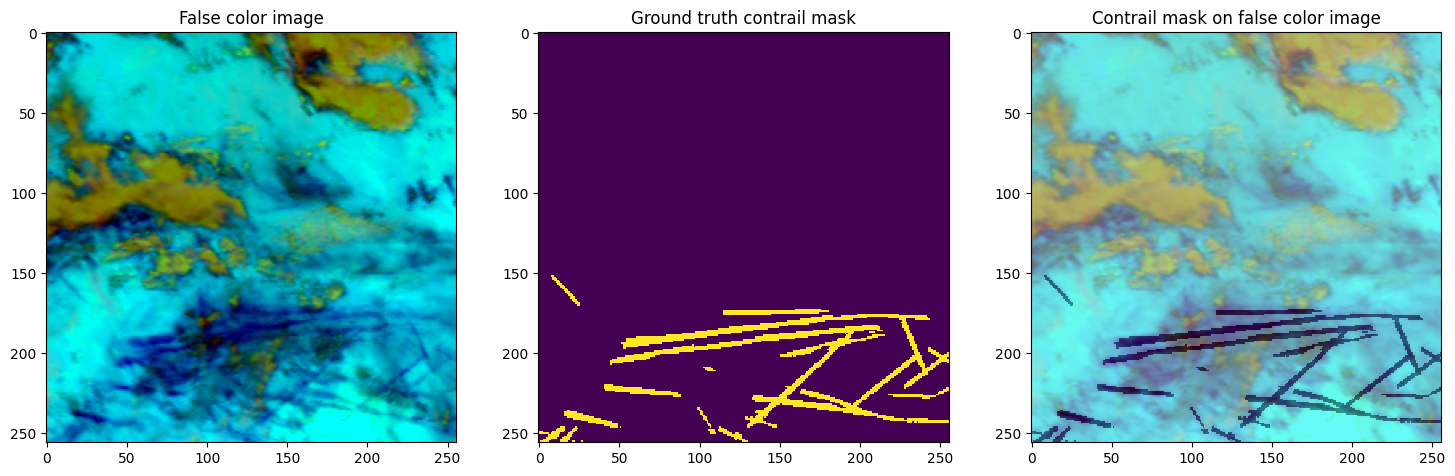

In [39]:
 x, y = train_dataset[train_ids.index('1704010292581573769')]
 plot_contrail(x, y)
 #animate_contrail(x)

In [40]:
# Dice Coefficient
def dice_coeff(mask1, mask2):
    intersect = torch.sum(mask1 * mask2)
    m1sum = torch.sum(mask1)
    m2sum = torch.sum(mask2)
    dice = (2 * intersect ) / (m1sum + m2sum)
    return dice.item()

# # Example
# mask1 = torch.randint(0,2,(10, 256,256))
# mask2 = torch.randint(0,2,(10, 256,256))
# print(dice_coeff(mask1, mask2))

In [41]:
# Callbacks
class History:
    def __init__(self, print_prefix, save_to_disk=True):
        self.train_batch_history = []
        self.val_batch_histroy = []
        self.train_epoch_history = []
        self.val_epoch_history = []
        self.running_train_batch_history = []
        self.running_val_batch_history = []
        self.print_prefix = print_prefix
        self.save_to_disk = save_to_disk
        if save_to_disk:
            #self.save_path = os.path.join(os.getcwd(),"saved_states",self.print_prefix)
            self.save_path = save_dir
            #if not os.path.exists(self.save_path):
                #os.makedirs(self.save_path)
                
    def on_train_batch_end(self, data):
        self.running_train_batch_history.append(data)
        
    def on_val_batch_end(self, data):
        self.running_val_batch_history.append(data)
        
    def on_epoch_end(self):
        self.train_epoch_history.append(np.mean(self.running_train_batch_history))
        self.train_batch_history.extend(self.running_train_batch_history)
        self.running_train_batch_history=[]
        self.val_epoch_history.append(np.mean(self.running_val_batch_history))
        self.val_batch_histroy.extend(self.running_val_batch_history)
        self.running_val_batch_history=[]
        print(f"{self.print_prefix}: Train = {self.train_epoch_history[-1]:.6f} \
        | Val = {self.val_epoch_history[-1]:.6f}")
    
    def on_end(self):
        if self.save_to_disk:
          #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
          np.save(os.path.join(self.save_path,"train_batch.npy"),self.train_batch_history)
          np.save(os.path.join(self.save_path,"val_batch.npy"),self.val_batch_histroy)
          np.save(os.path.join(self.save_path,"train_epoch.npy"),self.train_epoch_history)
          np.save(os.path.join(self.save_path,"val_epoch.npy"),self.val_epoch_history)

In [42]:
class BestStateTracker:
    def __init__(self, model, optim, trigger:History, save_to_disk:bool = False):
        self.trigger = trigger
        self.model = model
        self.optim = optim
        self.optim_state = None
        self.model_state = None
        self.best_loss = np.inf
        self.save_to_disk = save_to_disk
        if save_to_disk:
            #self.save_path = os.path.join(os.getcwd(),"saved_states")
            self.save_path = save_dir
            if not os.path.exists(self.save_path):
                os.mkdir(self.save_path)
                
    def on_epoch_end(self):
        if self.trigger.val_epoch_history[-1] < self.best_loss:
            self.model_state = self.model.state_dict()
            self.optim_state = self.optim.state_dict()
            
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            torch.save(self.model_state,os.path.join(self.save_path,f"model_state_end.pt"))
            torch.save(self.optim_state,os.path.join(self.save_path,f"optim_state_end.pt"))
            #torch.save(self.model_state,os.path.join(self.save_path,f"model_state_{dt}.pt"))
            #torch.save(self.optim_state,os.path.join(self.save_path,f"optim_state_{dt}.pt"))

In [43]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, dilations):
        super(ASPP, self).__init__()
        self.aspp_blocks = nn.ModuleList()
        for dilation in dilations:
            self.aspp_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
                )

    def forward(self, x):
        return sum(block(x) for block in self.aspp_blocks)

In [44]:
ENCODER = 'timm-efficientnet-b1'
ENCODER_WEIGHTS = 'imagenet' #'noisy-student'

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(DEVICE)

In [45]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
      super(Focal_MultiLabel_Loss, self).__init__()
      self.gamma = gamma
      self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets): 
      bce = self.bceloss(outputs, targets)
      bce_exp = torch.exp(-bce)
      focal_loss = (1-bce_exp)**self.gamma * bce
      return focal_loss.mean()

In [46]:
print(save_dir)

/content/drive/MyDrive/Contrail/experiments-Unet2D_DeepLabV3/20230529-011955


In [66]:
load_dir ='/content/drive/MyDrive/Contrail/experiments-Unet2D_DeepLabV3/checkpoint'

In [67]:
Save_PATH = f'{load_dir}/model_checkpoint.pth'

#Save_PATH = f'{save_dir}/model_checkpoint.pth'

In [68]:
LR = 2e-3
EPOCHS = 10


FLAGS={}
#FLAGS['num_cores'] = 8
FLAGS['start_epoch'] = 1
FLAGS['num_epochs'] = EPOCHS
FLAGS['num_workers'] = 12
#FLAGS['log_steps'] = 20
FLAGS['save_path'] = Save_PATH
FLAGS['seed'] = 1234
FLAGS['max_lr'] = LR
FLAGS['min_lr'] = 0.0005
FLAGS['warmup_steps'] = 2

In [69]:


'''model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=3, out_channels=1, init_features=32, 
                       pretrained=False).to(DEVICE)'''

optimizer = Adam(params=model.parameters(), lr=LR)
#loss_fn = BCELoss()
loss_fn = Focal_MultiLabel_Loss(gamma=2) 

#scheduler = ReduceLROnPlateau(optimizer)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=Train_max)

scheduler = CosineLRScheduler(optimizer, 
                              t_initial=EPOCHS, 
                              lr_min=FLAGS['min_lr'], 
                              warmup_t=FLAGS['warmup_steps'],
                              warmup_lr_init=5e-5,
                              warmup_prefix=True)

loss_tracker = History(print_prefix="Loss")
dice_tracker = History(print_prefix="Dice")
save_state = BestStateTracker(model,optimizer,loss_tracker,save_to_disk=True)

'''scheduler = CosineAnnealingWarmupRestarts(
    optimizer,
    first_cycle_steps=EPOCHS,
    max_lr=FLAGS['max_lr'],
    min_lr=FLAGS['min_lr'],
    warmup_steps=FLAGS['warmup_steps'])'''

"scheduler = CosineAnnealingWarmupRestarts(\n    optimizer,\n    first_cycle_steps=EPOCHS,\n    max_lr=FLAGS['max_lr'],\n    min_lr=FLAGS['min_lr'],\n    warmup_steps=FLAGS['warmup_steps'])"

In [63]:
#print(model)

# Train

In [ ]:
start_epoch = 0
time_frame = 4

if os.path.exists(Save_PATH):
    checkpoint = torch.load(Save_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']+1
    #loss = checkpoint['loss']
    print("Loaded checkpoint.")
else:
  start_epoch = 0

pbar = tqdm(range(start_epoch, EPOCHS))
time_frame = 4

for epoch in pbar:
 print(f"\nEPOCH: {epoch+1}/{EPOCHS}")
 current_lr = optimizer.param_groups[0]['lr']
 print(f'Epoch: {epoch+1}, Learning rate: {current_lr}')
 
 model.train()
 for idx, (data, target) in enumerate(train_loader):
     data, target = data.to(DEVICE), target.to(DEVICE) #Copy to GPU if available
     #data = data.permute(0, 2, 1, 3, 4)
     y_pred = model(data)
     #y_pred = y_pred[:,:,time_frame, :]
     loss = loss_fn(y_pred, target)
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     loss_tracker.on_train_batch_end(loss.item())
     #dice_tracker.on_train_batch_end(dice_coeff(y_pred>0.5, target))
     pbar.set_description(f"Train Batch: {idx+1}/{len(train_loader)}\
     | Loss: {loss.item():.6f}")

 #plot_contrail_comparision(data[0].cpu().detach(),target[0].cpu().detach(),y_pred[0].cpu().detach()>0.5)

 model.eval()    
 with torch.no_grad():
     for idx, (data, target) in enumerate(val_loader):
         data, target = data.to(DEVICE), target.to(DEVICE) #Copy to GPU if available
         #data = data.permute(0, 2, 1, 3, 4)
         y_pred = model(data)
         #y_pred = y_pred[:,:,time_frame, :]   
         loss = loss_fn(y_pred, target)
         loss_tracker.on_val_batch_end(loss.item())
         #dice_tracker.on_val_batch_end(dice_coeff(y_pred>0.5, target))
         pbar.set_description(f"Val Batch:   {idx+1}/{len(val_loader)}\
         | Loss: {loss.item():.6f}")


     #plot_contrail_comparision(data[0].cpu().detach(),target[0].cpu().detach(),y_pred[0].cpu().detach()>0.5)
 
 #print("Train sample(above), Val sample(below)")
 torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    #'loss': running_loss / len(trainloader),
    }, Save_PATH)
 #ofilename = f'{save_dir}/model_epoch{epoch}.pytorch'
 #torch.save(model.state_dict(), ofilename)
 scheduler.step()
 loss_tracker.on_epoch_end()
 #dice_tracker.on_epoch_end()
 save_state.on_epoch_end()

save_state.on_end()
loss_tracker.on_end()
#dice_tracker.on_end()

Loaded checkpoint.


  0%|          | 0/9 [00:00<?, ?it/s]


EPOCH: 2/10
Epoch: 2, Learning rate: 0.0005


Train Batch: 161/1283     | Loss: 0.008033:   0%|          | 0/9 [04:37<?, ?it/s]